In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import time
import seaborn as sns

import pymeasure.instruments.srs as srs

reload(srs)
lockin = srs.SR830('GPIB2::9::INSTR')
# lockin = srs.SR830('GPIB0::12::INSTR')
print(lockin.id)

lockin.time_constant = 0.1
lockin.filter_slope = 24
print(f'time constant is {lockin.time_constant}')
print(f'filter rolloff slope is {lockin.filter_slope}')
# print(lockin.x, lockin.y)


# set the sample frequency to be 10 time constants (or roughly that, if you use filter slope of 24db/oct)
samp_freq = 1
buffer_size = 30

lockin.sample_frequency = samp_freq

print(f'lockin buffer sampling frequency is {lockin.sample_frequency}')
print(f'The number of samples to be collected is {buffer_size}')

Stanford_Research_Systems,SR830,s/n86942,ver1.07
time constant is 0.1
filter rolloff slope is 24
lockin buffer sampling frequency is 1
The number of samples to be collected is 30


Tune the scalings and collect a sample of data

In [2]:
# print(lockin.get_scaling('X'))
# print(lockin.get_scaling('Y'))

for ch in ['X', 'Y']:
    lockin.set_scaling(ch, 0, expand = 1)
    print('The is turned of ', lockin.get_scaling(ch))

print('Lockin xy is ', lockin.xy)

def fastbuffer_to_float(response):
    float_response = np.frombuffer(response, dtype = np.int16)*lockin.sensitivity/3e4
    x = float_response[0::2]
    y = float_response[1::2]
    return x, y

def zero_and_expand(instr:srs.SR830, ch, expansion = 1):
    instr.auto_offset(channel = ch)
    # per, exp = instr.get_scaling(ch)
    instr.set_scaling(ch, expand = expansion)

for ch in ['X', 'Y']:
    zero_and_expand(lockin, ch, expansion = 100)
    print('The new scaling is ', lockin.get_scaling(ch))

print(lockin.lia_status)

res = lockin.buffer_measure(
    buffer_size = buffer_size,
    fast = True,
    )

x_response, y_response = fastbuffer_to_float(res)

x_vals = lockin.output_conversion('X')(x_response)
y_vals = lockin.output_conversion('Y')(y_response)


The is turned of  (0.0, 1)
The is turned of  (0.0, 1)
Lockin xy is  [0.0105506, -0.0101367]
The new scaling is  (52.75, 100)
The new scaling is  (-50.68, 100)
0
buffer stopped at time  29.49133324623108
read buffer cleared at time  30.541066646575928
measurement complete at  30.541066646575928


Process bytes to floats

Adjusting the readout for scaling

In [3]:
x_precision = np.abs(np.min(np.diff(x_vals)))
y_precision = np.abs(np.min(np.diff(y_vals)))

print(f'typical precision at a sensitivity of {lockin.sensitivity*1e3}mV is  {1e3*20/(3*10**4)}uV')
print(f'precision in the measruement of the X channel is {x_precision*1e6}uV')
print(f'precision in the measurement of the Y channel is {y_precision*1e6}uV')

typical precision at a sensitivity of 20.0mV is  0.6666666666666666uV
precision in the measruement of the X channel is 0.44666666666748345uV
precision in the measurement of the Y channel is 0.6133333333331603uV


Text(0, 0.5, '$Y$ (mV)')

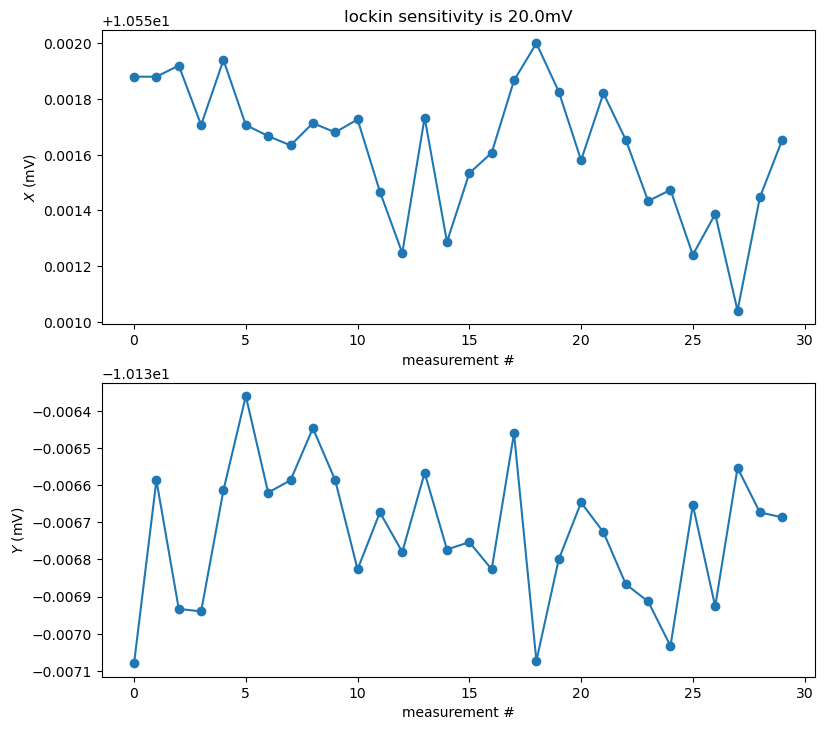

In [4]:
fig, ax = plt.subplots(2,1, figsize = (9.2, 5.6*1.5))
axa, axb = ax

axa.set_title(f'lockin sensitivity is {lockin.sensitivity*1e3}mV')
axa.plot(x_vals*1e3, 'o-')
axb.plot(y_vals*1e3, 'o-')

axa.set_xlabel('measurement #')
axa.set_ylabel(r'$X$ (mV)')

axb.set_xlabel(axa.get_xlabel())
axb.set_ylabel(r'$Y$ (mV)')
# axa.legend()

Channel X scaling should be off: f(0.0, 1)
Channel Y scaling should be off: f(0.0, 1)
buffer stopped at time  29.495213270187378
read buffer cleared at time  30.545580625534058
measurement complete at  30.545580625534058


Text(0, 0.5, '$Y$ (mV)')

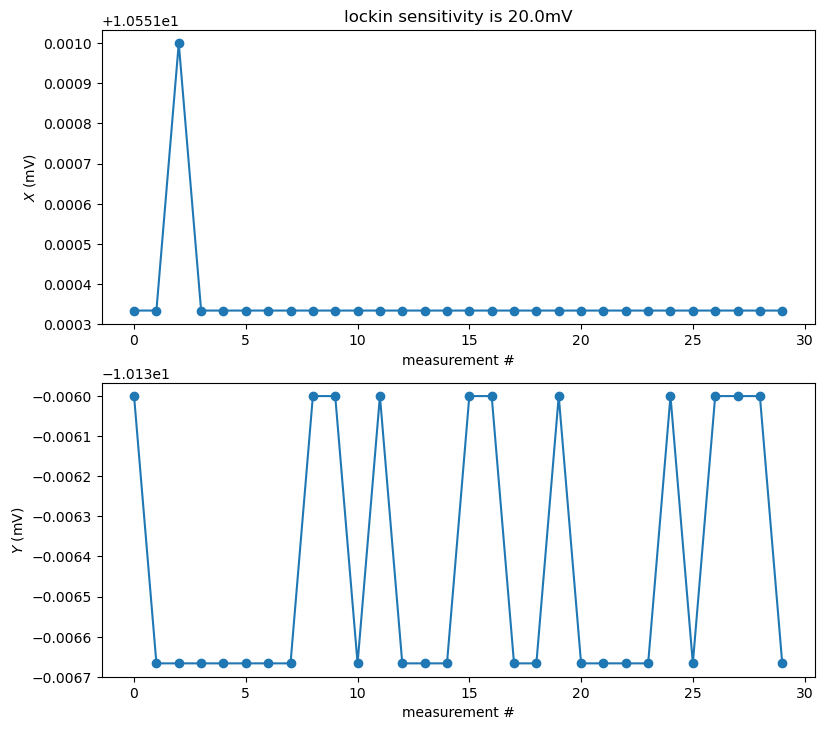

In [5]:
for ch in ['X', 'Y']:
    lockin.set_scaling(ch, 0, 0)
    print(f'Channel {ch} scaling should be off: f{lockin.get_scaling(ch)}')

res_unscale = lockin.buffer_measure(buffer_size, fast=True)
x_unscale, y_unscale = fastbuffer_to_float(res_unscale)
x_unscale = lockin.output_conversion('X')(x_unscale)
y_unscale = lockin.output_conversion('Y')(y_unscale)

fig, ax = plt.subplots(2,1, figsize = (9.2, 5.6*1.5))
axa, axb = ax

axa.set_title(f'lockin sensitivity is {lockin.sensitivity*1e3}mV')
axa.plot(x_unscale*1e3, 'o-')
axb.plot(y_unscale*1e3, 'o-')

axa.set_xlabel('measurement #')
axa.set_ylabel(r'$X$ (mV)')

axb.set_xlabel(axa.get_xlabel())
axb.set_ylabel(r'$Y$ (mV)')
# axa.legend()

Text(0, 0.5, '$Y$ (mV)')

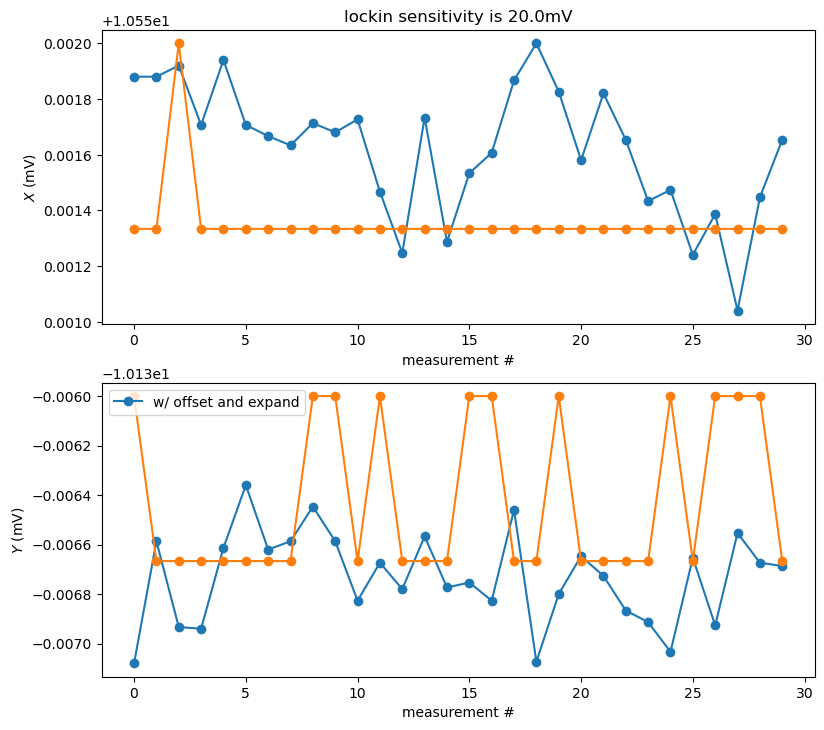

In [6]:
fig, ax = plt.subplots(2,1, figsize = (9.2, 5.6*1.5))
axa, axb = ax

axa.set_title(f'lockin sensitivity is {lockin.sensitivity*1e3}mV')
axa.plot(x_vals*1e3, 'o-')
axa.plot(x_unscale*1e3, 'o-')

axb.plot(y_vals*1e3, 'o-', label ='w/ offset and expand')
axb.plot(y_unscale*1e3, 'o-')
axb.legend()

axa.set_xlabel('measurement #')
axa.set_ylabel(r'$X$ (mV)')

axb.set_xlabel(axa.get_xlabel())
axb.set_ylabel(r'$Y$ (mV)')